# Imports

In [1]:
from transformers import BertTokenizer, TFBertForMaskedLM, BertConfig
import tensorflow as tf
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize tokenizer

In [8]:
tokenizer = BertTokenizer(
    vocab_file="./vocab.txt"
)

In [9]:
tokenizer

BertTokenizer(name_or_path='', vocab_size=26, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	26: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	27: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	28: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	29: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

# Initialize Token

In [4]:
# model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

In [10]:
config = BertConfig(
    vocab_size = 31, 
    hidden_size = 64, 
    num_hidden_layers = 2, 
    num_attention_heads = 1, 
    intermediate_size = 64, 
    hidden_act = "gelu", 
    hidden_dropout_prob = 0.1, 
    attention_probs_dropout_prob = 0.1, 
    max_position_embeddings = 40, 
    type_vocab_size = 1, 
    initializer_range = 0.02,
    layer_norm_eps = 1e-12, 
    pad_token_id = 28
)

In [11]:
model = TFBertForMaskedLM(config=config)

In [15]:
# dir(model)

# Load Dataset

In [2]:
## Load Dataset
data_location = "../data/words_250000_train.txt"
with open(data_location,'r') as f:
    word_list = f.read().splitlines()
word_list[:2]

['aaa', 'aaaaaa']

In [3]:
word_list = list(set(word_list))
len(word_list)

227300

In [4]:
def get_clean_word(word):
    clean_word = list(word.strip().lower())
    return clean_word

In [5]:
train_word_list = []
train_word_length_list = []
for word in tqdm(word_list):
    if len(word) >=3:
        clean_word = get_clean_word(word)
        train_word_list.append(clean_word)
        train_word_length_list.append(len(clean_word))

100%|██████████| 227300/227300 [00:01<00:00, 183651.12it/s]


In [6]:
char_count_dict = {}
for word in train_word_list:
    for c in word:
        if(c in char_count_dict.keys()):
            char_count_dict[c] += 1
        else:
            char_count_dict[c] = 1

In [9]:
dict(sorted(char_count_dict.items(), key=lambda item: item[1], reverse=True))

{'e': 233720,
 'i': 184721,
 'a': 179815,
 'n': 152238,
 'o': 150029,
 'r': 149202,
 's': 148441,
 't': 137257,
 'l': 122410,
 'c': 89340,
 'u': 77282,
 'd': 74830,
 'p': 65765,
 'm': 62173,
 'h': 58025,
 'g': 51834,
 'y': 40969,
 'b': 39823,
 'f': 26409,
 'v': 21037,
 'k': 18667,
 'w': 17705,
 'z': 8735,
 'x': 6030,
 'q': 3970,
 'j': 3774}

In [20]:
len(train_word_list), train_word_list[:2]

(227019,
 [['o', 'v', 'e', 'r', 'c', 'o', 'm', 'm', 'i', 't', 'e', 'd'],
  ['p', 'a', 'e', 'g', 'l', 'e']])

In [21]:
inputs = tokenizer(train_word_list, is_split_into_words=True, max_length=40, truncation=True, padding='max_length', return_tensors='tf')
print(inputs.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [22]:
inputs["input_ids"][:1]

<tf.Tensor: shape=(1, 40), dtype=int32, numpy=
array([[29, 14, 21,  4, 17,  2, 14, 12, 12,  8, 19,  4,  3, 27, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28]])>

In [23]:
inputs['labels'] = inputs['input_ids']
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [24]:
## Masking Input tokens
inp_ids = []
idx = 0
for inp in tqdm(inputs.input_ids.numpy()):
    actual_tokens = list(set(range(40)) - set(np.where((inp == 26) | (inp == 27) | (inp == 28) | (inp == 29))[0].tolist()))
    #We need to select 15% random tokens from the given list
    num_of_token_to_mask = int(len(actual_tokens)*0.15)
    token_to_mask = np.random.choice(np.array(actual_tokens), size=num_of_token_to_mask, replace=False).tolist()
    #Now we have the indices where we need to mask the tokens
    inp[token_to_mask] = 30
    inp_ids.append(inp)
    idx += 1
inp_ids = tf.convert_to_tensor(inp_ids)
inputs['input_ids'] = inp_ids

  0%|          | 821/227019 [00:00<00:27, 8157.03it/s]

100%|██████████| 227019/227019 [00:20<00:00, 11107.87it/s]


In [25]:
idx

227019

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)
history = model.fit(
    [inputs.input_ids, inputs.attention_mask],
    inputs.labels,
    verbose=2,
    batch_size=10000,
    epochs=10
)

Epoch 1/10
23/23 - 429s - loss: 3.1743 - 429s/epoch - 19s/step
Epoch 2/10
23/23 - 467s - loss: 2.7387 - 467s/epoch - 20s/step
Epoch 3/10
23/23 - 385s - loss: 2.4564 - 385s/epoch - 17s/step
Epoch 4/10
23/23 - 366s - loss: 2.2178 - 366s/epoch - 16s/step
Epoch 5/10
23/23 - 370s - loss: 1.9935 - 370s/epoch - 16s/step
Epoch 6/10
23/23 - 369s - loss: 1.7896 - 369s/epoch - 16s/step
Epoch 7/10
23/23 - 373s - loss: 1.6080 - 373s/epoch - 16s/step
Epoch 8/10
23/23 - 346s - loss: 1.4484 - 346s/epoch - 15s/step
Epoch 9/10
23/23 - 342s - loss: 1.3088 - 342s/epoch - 15s/step
Epoch 10/10
23/23 - 344s - loss: 1.1876 - 344s/epoch - 15s/step


In [50]:
query = ["b", "o", "[MASK]"]
inp = tokenizer(query, is_split_into_words=True, return_tensors='tf')
mask_loc = np.where(inp.input_ids.numpy()[0] == 30)[0].tolist()
out = model(inp).logits[0].numpy()
predicted_tokens = np.argmax(out[mask_loc], axis=1).tolist()
tokenizer.decode(predicted_tokens)

'e'

In [58]:
out

array([[-0.27679357, -0.338985  , -0.10742649,  0.10083949, -0.9210248 ,
        -0.09017365, -0.3276728 ,  0.05279489, -0.3647586 , -0.09019911,
        -0.05861327, -0.13069992, -0.06866825, -0.21243714,  0.40576547,
         0.2650085 , -0.18225044, -0.19266751,  0.3916106 , -0.31123182,
        -0.12884448, -0.05248813,  0.16782619, -0.08273708,  0.21478567,
        -0.4324103 , -0.4283368 ,  0.06984731,  0.03559908,  1.797891  ,
        -0.11240901],
       [ 0.07614097,  1.069359  ,  0.8810755 ,  0.83474195,  0.56857467,
         0.68590575,  0.8021957 ,  0.67443436,  0.3109207 ,  0.45508862,
         0.50094163,  0.50113755,  0.64731544,  0.66054267,  0.43858123,
         0.44719502,  0.5319291 ,  0.22216901,  0.63286906,  0.94916785,
         0.92308116,  0.56172955,  0.517453  ,  0.49069142,  0.57480425,
         0.47428   ,  0.5744245 , -0.03283438, -1.0423594 ,  0.0631012 ,
         0.34942305],
       [-0.66965026, -0.10346151, -0.10133345,  0.08920237,  0.03573318,
       

In [57]:
np.argsort(out[mask_loc][0])

array([28, 26, 25,  5, 21, 22, 18, 27, 23,  9, 30,  1, 16, 10,  7,  2, 12,
        6, 24,  3, 15, 29,  8,  0, 20, 17, 14, 19, 11, 13,  4],
      dtype=int64)

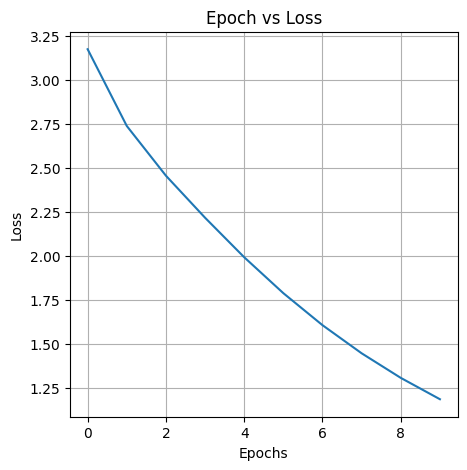

In [49]:
losses = history.history['loss']
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)),losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()